In [2]:
import scipy.io as scio
import os
import numpy as np
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
from functools import lru_cache
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import math
os.chdir('/Users/sheeta/Desktop/learn_torch/Task3')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Unpack the mat format into python

In [7]:
#load raman
spec_mat= scio.loadmat('scale_spec')
specdata = torch.Tensor(spec_mat['ans'])

#load label
label_mat= scio.loadmat('label')
labeldata = torch.Tensor(label_mat['label'])


In [8]:
onecount=0
for i in labeldata:
    if i ==1:
        onecount+=1

In [9]:
zerocount=0
for i in labeldata:
    if i ==0:
        zerocount+=1
print(zerocount)

4727


In [10]:
onecount

1406

## Data class

In [18]:
input_size = math.floor(779/2)
output_size = 1
epochs = 40
batch_size = 20
random_seed= 42
#mixed, control 在前

In [20]:
spec_down = np.load('spec_down.npy')

In [3]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset
        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)

    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=batch_size):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size)
        self.val_loader = self.get_validation_loader(batch_size=batch_size)
        self.test_loader = self.get_test_loader(batch_size=batch_size)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=batch_size):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset,batch_size=batch_size,sampler=self.train_sampler, shuffle=False)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=batch_size):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size,sampler=self.val_sampler, shuffle=False)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=batch_size):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset,batch_size=batch_size, sampler=self.test_sampler, shuffle=False)
        return self.test_loader
    
    

class OSCCDataset(Dataset):
    def __init__(self, transform = None):
        #Dataloading
        self.x = spec_down
        self.y = labeldata
        self.samples= len(self.x)
        self.transform = transform
    def __getitem__(self,index):
        #Dataset[0]
        spec = self.x[index]
        label = self.y[index]
        
        sample = spec,label
        if self.transform:
            sample = self.transform(sample)
        return sample
        
    def __len__(self):
        return self.samples
    

dataset = OSCCDataset()
split = DataSplit(dataset, shuffle = True)

train_loader, val_loader, test_loader = split.get_split(batch_size=32)

NameError: name 'batch_size' is not defined

In [22]:
# dataiter = iter(train_loader)
# x,y = dataiter.next()
# print(x.shape, y.shape)

torch.Size([32, 389]) torch.Size([32, 1])


# CNN network

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        n_c = 64
        self.feat_extractor = nn.Sequential(
                                nn.Conv1d(in_channels=1, out_channels=n_c, kernel_size=11, stride=5, padding=0, bias=False),
                                nn.BatchNorm1d(n_c),
                                nn.ReLU(),
                                nn.Conv1d(in_channels=n_c, out_channels=n_c, kernel_size=7, stride=3, padding=0, bias=False),
                                nn.BatchNorm1d(n_c),
                                nn.ReLU(),
                                )
        self.feat_mapping = nn.Sequential(
                                nn.Conv1d(in_channels=n_c, out_channels=n_c, kernel_size=3, stride=1, padding=1, bias=False),
                                nn.BatchNorm1d(n_c),
                                nn.ReLU(),
                                nn.Conv1d(in_channels=n_c, out_channels=n_c, kernel_size=3, stride=1, padding=1, bias=False),
                                nn.BatchNorm1d(n_c),
                                nn.ReLU(),
                                )
        self.classifier = nn.Sequential(
                            nn.AdaptiveAvgPool1d(1), 
                            Flatten(), 
                            nn.Linear(in_features=n_c, out_features=2, bias=True),
                            )
    def forward(self, x):
        out = self.feat_extractor(x)
        out = out + self.feat_mapping(out)
        y = self.classifier(out)
        return y

    
net = CNN()


## Training loop

In [5]:
net

CNN(
  (feat_extractor): Sequential(
    (0): Conv1d(1, 64, kernel_size=(11,), stride=(5,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(7,), stride=(3,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (feat_mapping): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

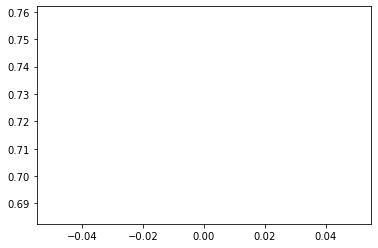

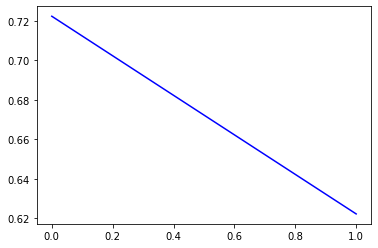

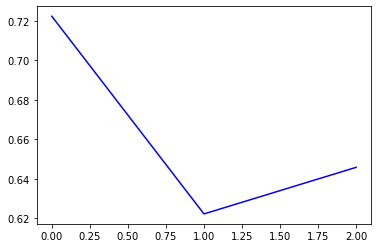

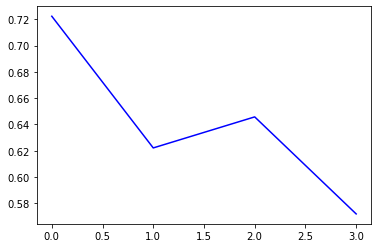

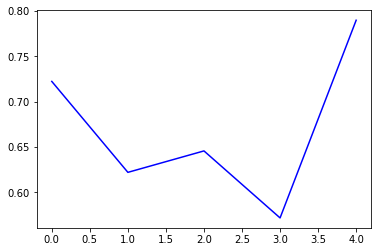

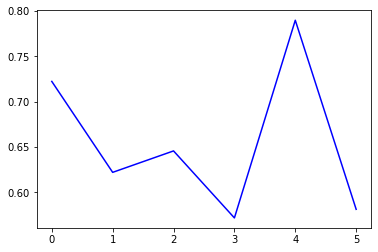

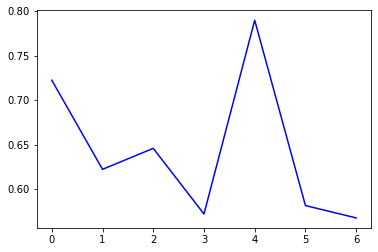

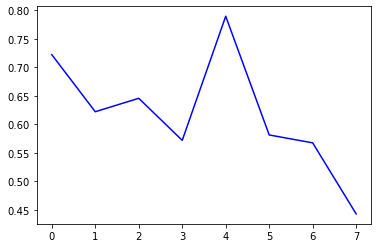

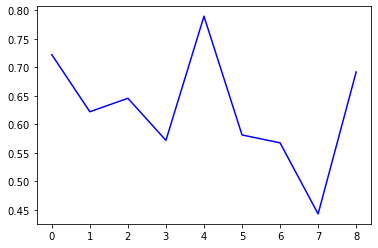

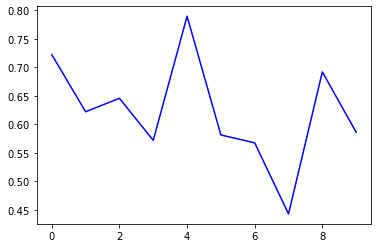

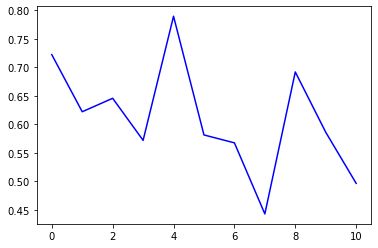

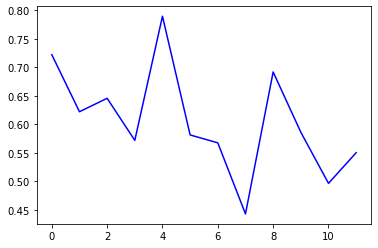

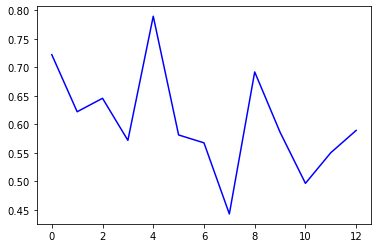

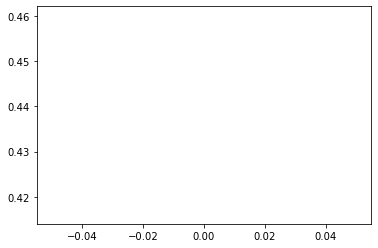

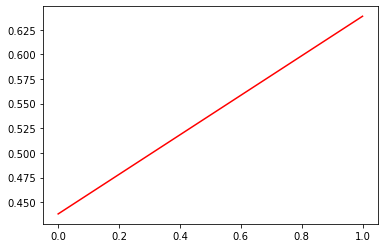

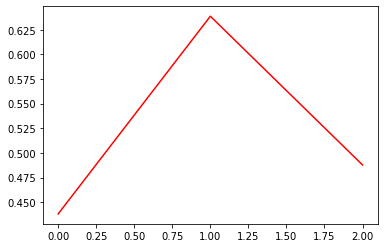

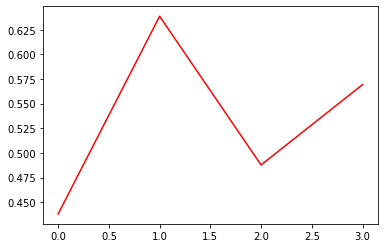

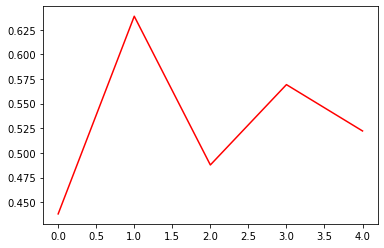

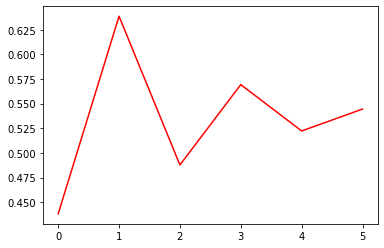

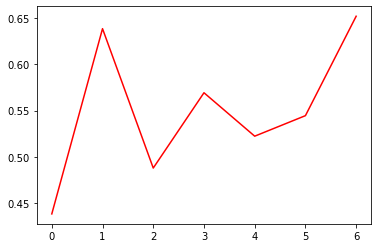

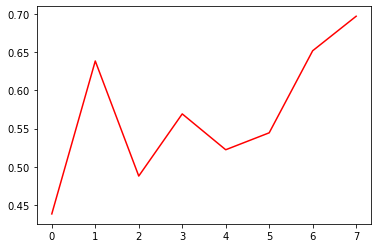

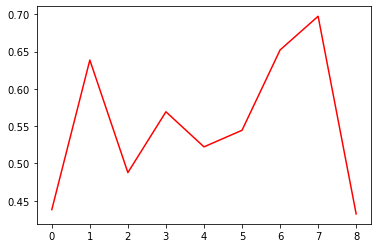

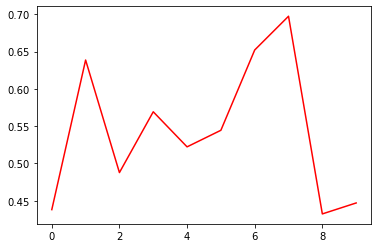

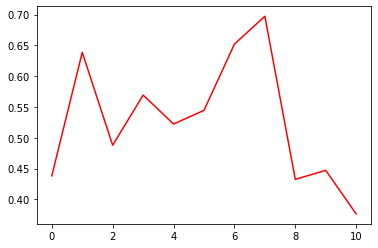

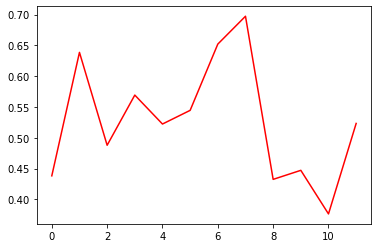

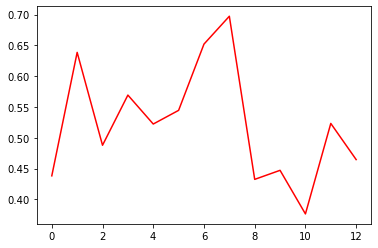

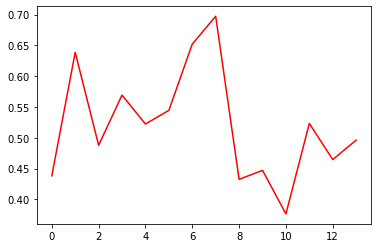

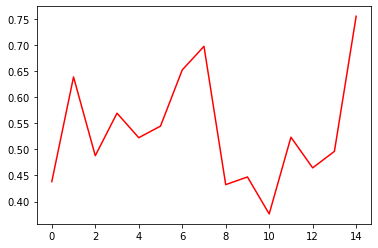

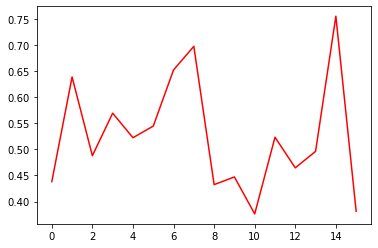

Epoch1,train loss 0.6045020658236283
Epoch1,val acc 75.56008146639512


  0%|          | 0/138 [00:00<?, ?it/s]

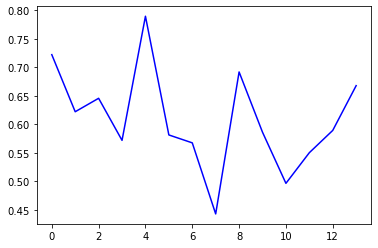

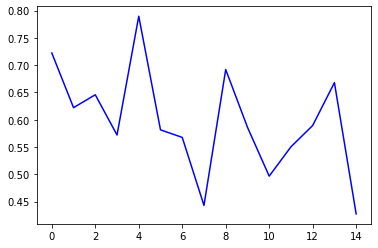

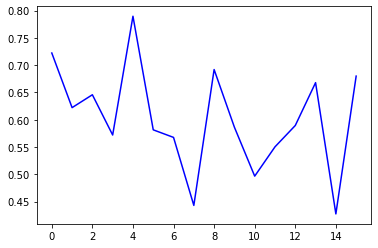

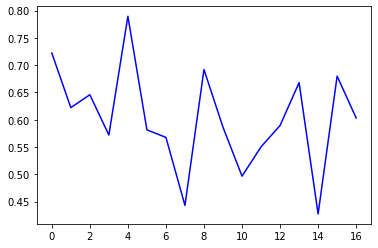

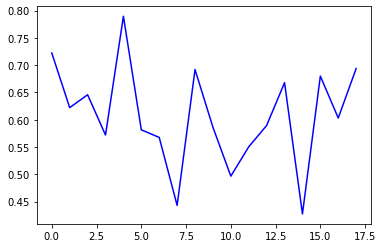

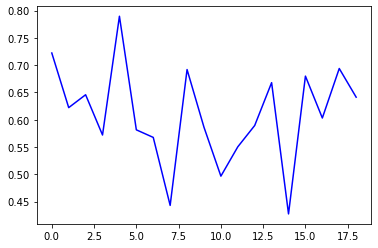

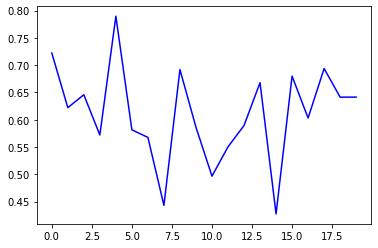

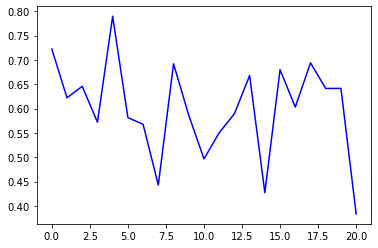

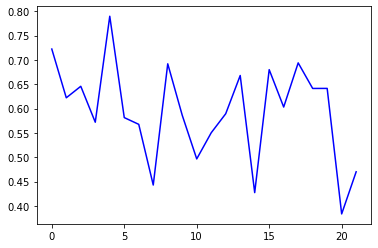

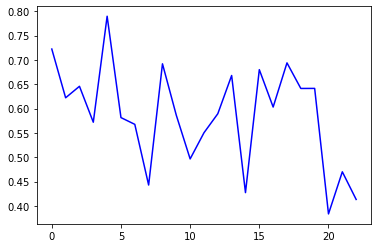

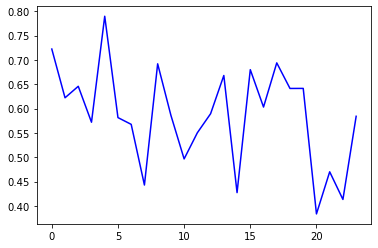

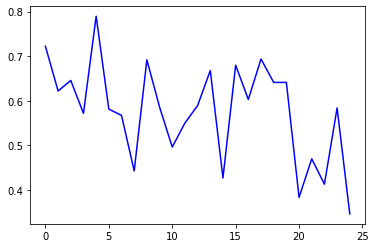

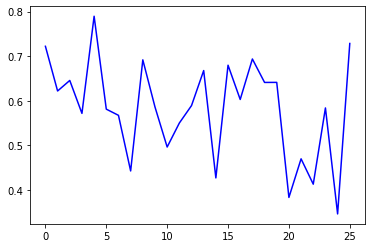

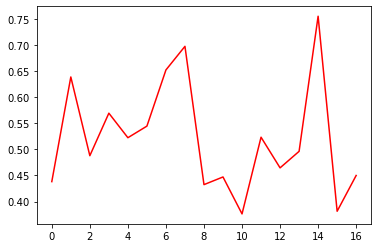

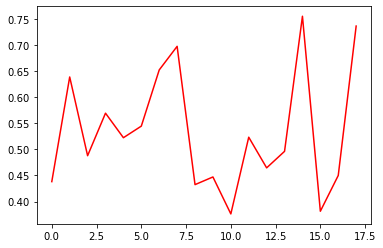

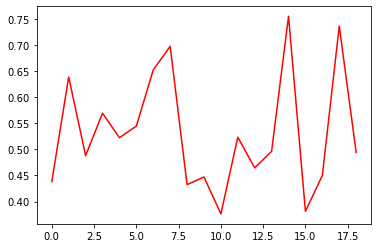

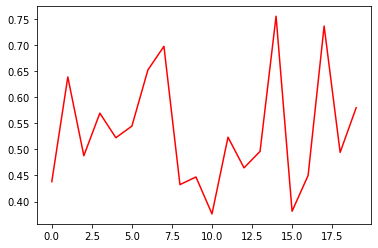

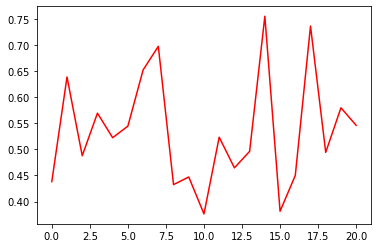

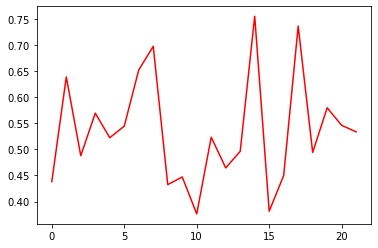

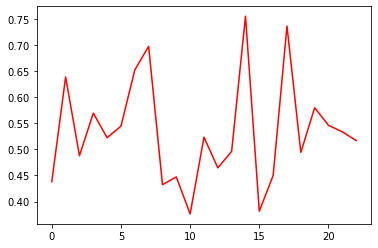

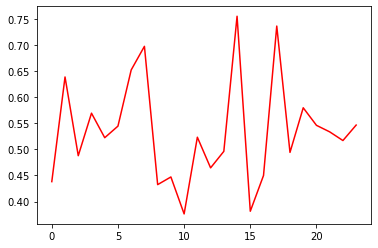

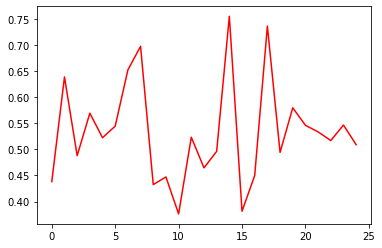

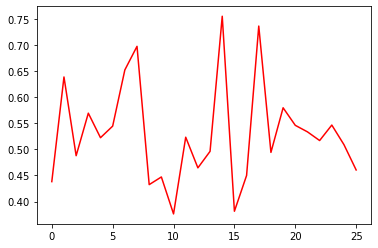

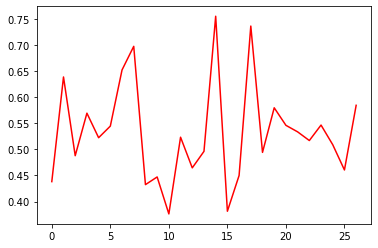

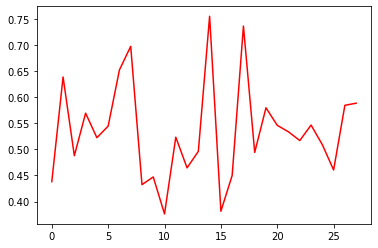

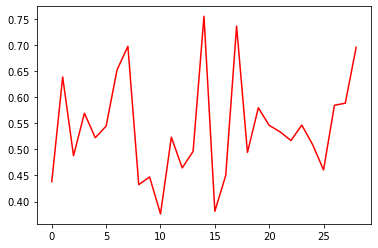

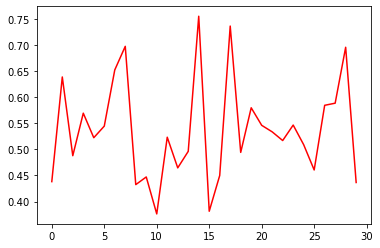

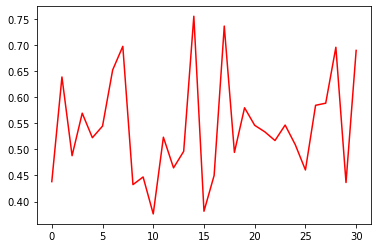

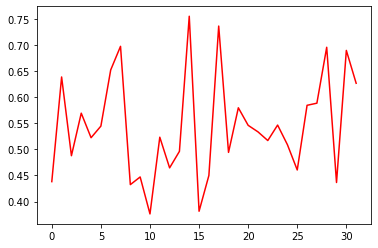

Epoch2,train loss 0.5823113425419881
Epoch2,val acc 64.35845213849286


  0%|          | 0/138 [00:00<?, ?it/s]

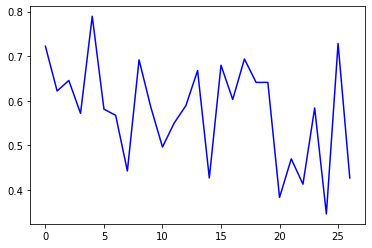

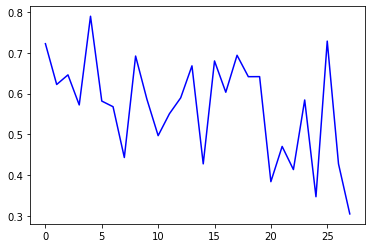

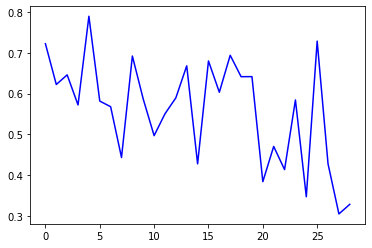

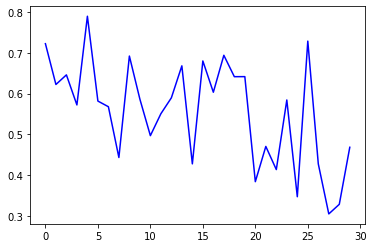

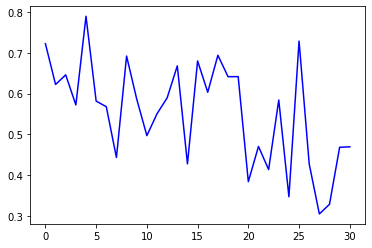

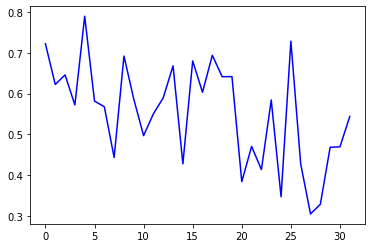

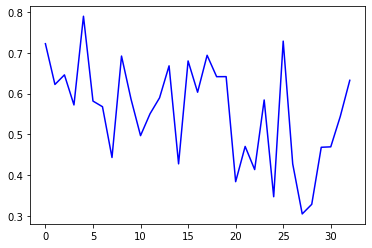

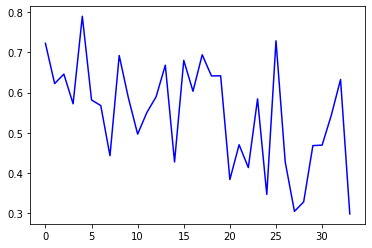

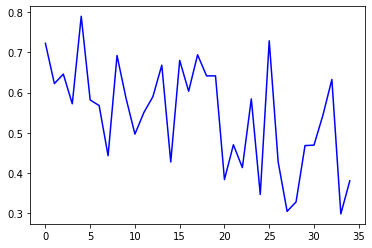

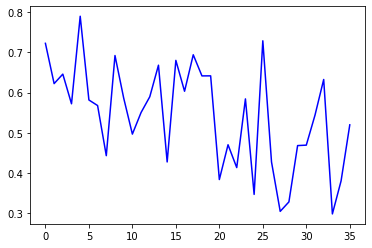

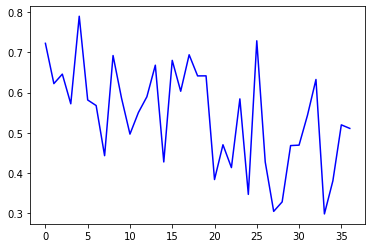

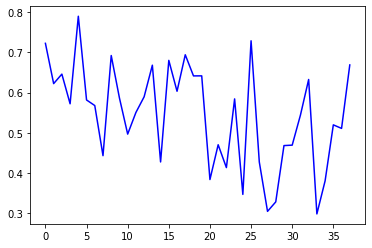

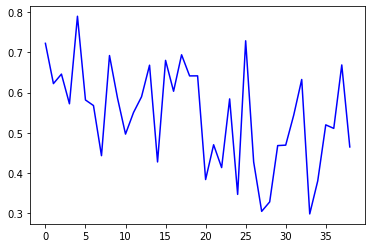

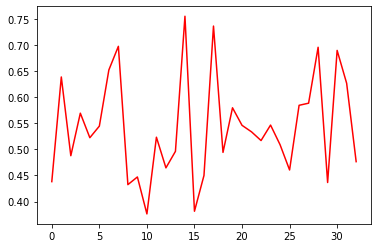

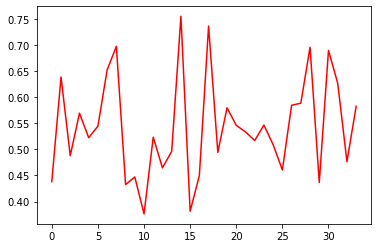

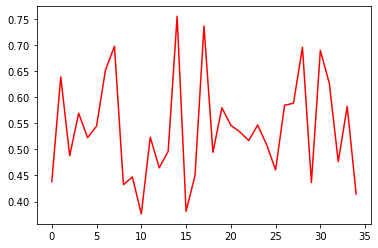

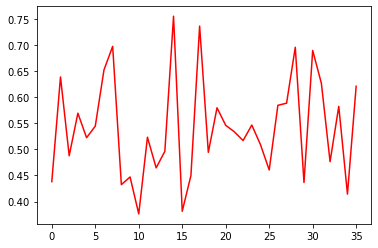

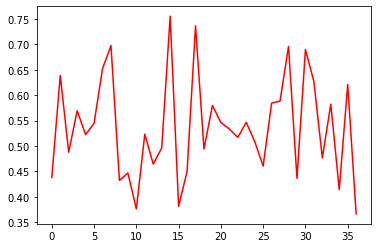

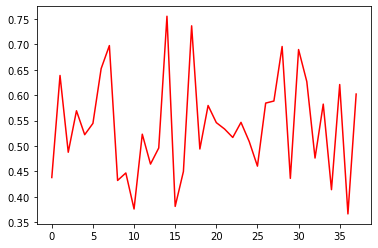

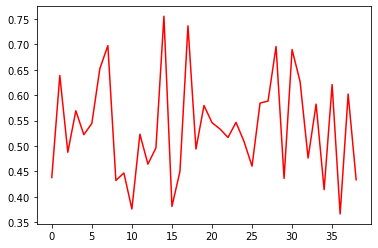

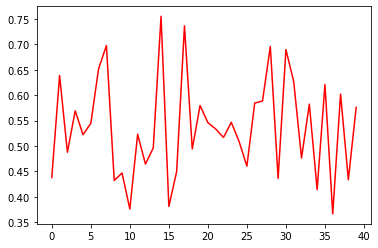

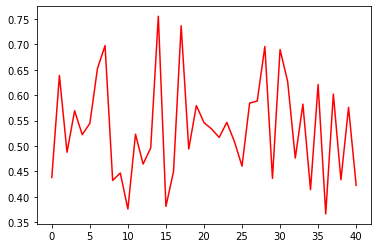

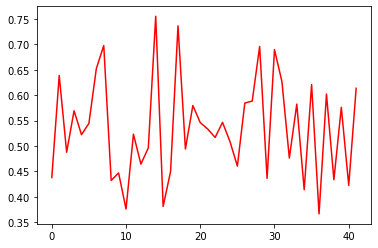

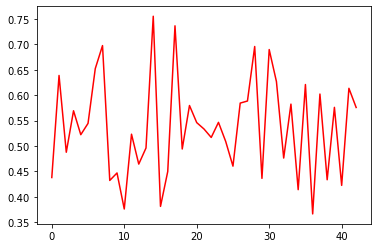

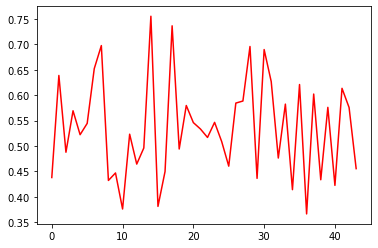

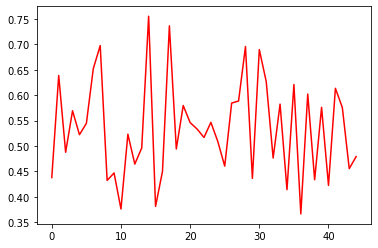

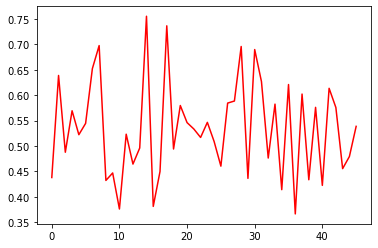

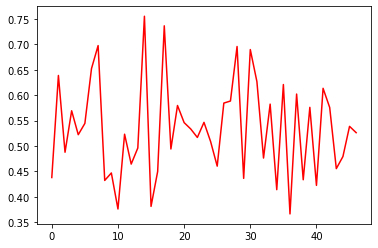

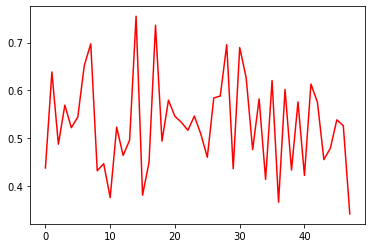

Epoch3,train loss 0.5424455786362673
Epoch3,val acc 73.72708757637474


  0%|          | 0/138 [00:00<?, ?it/s]

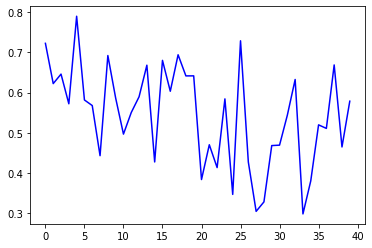

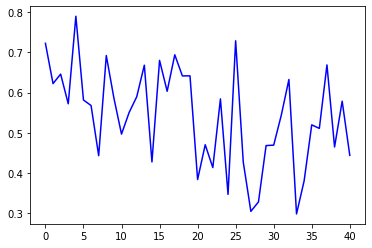

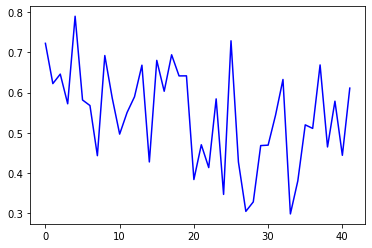

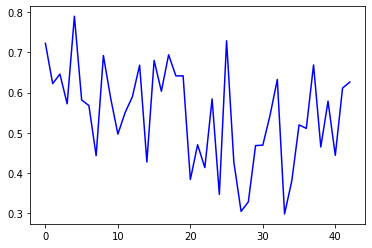

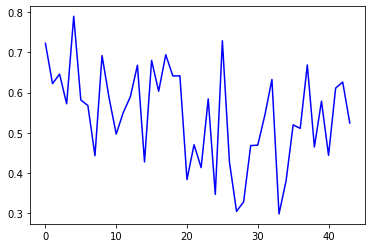

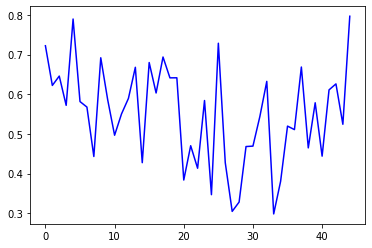

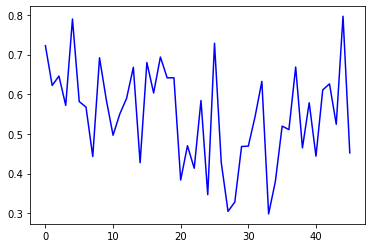

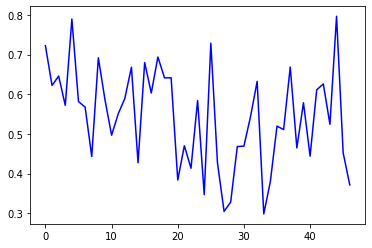

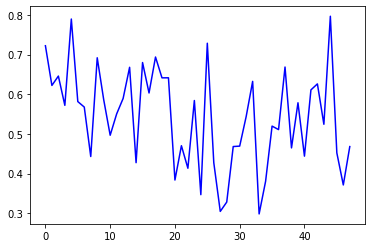

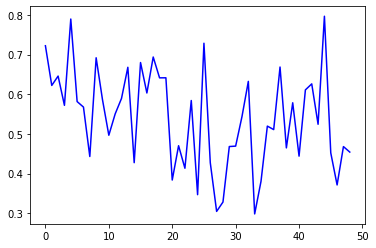

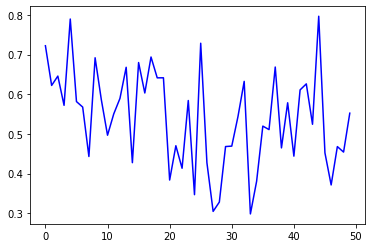

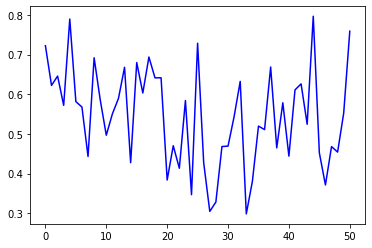

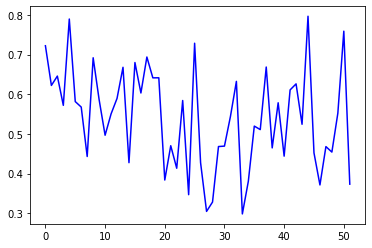

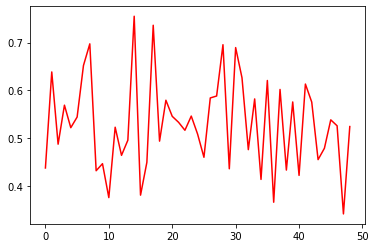

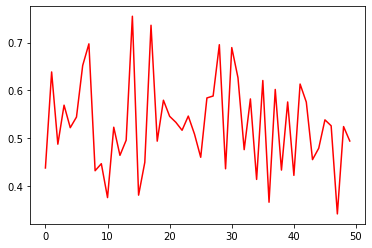

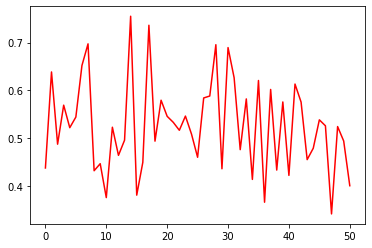

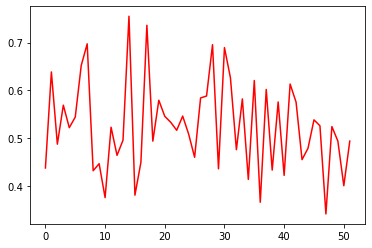

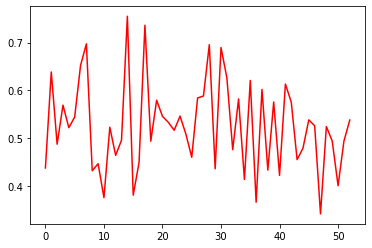

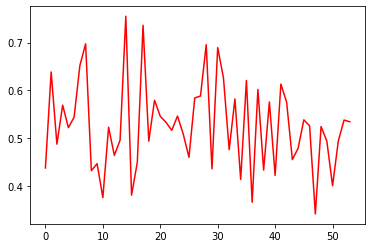

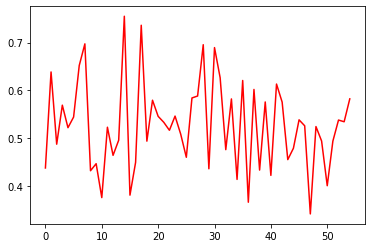

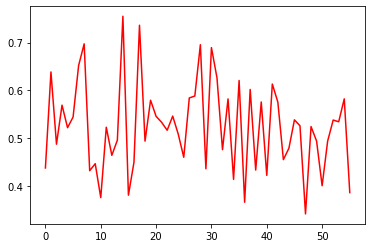

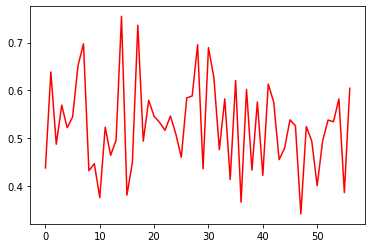

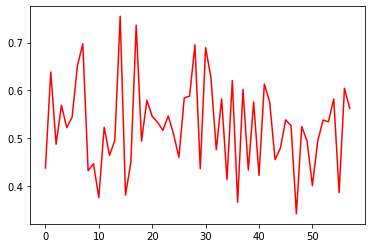

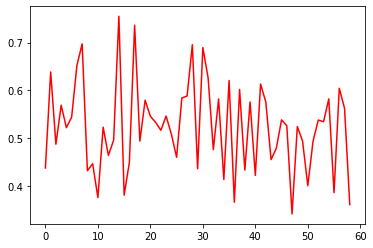

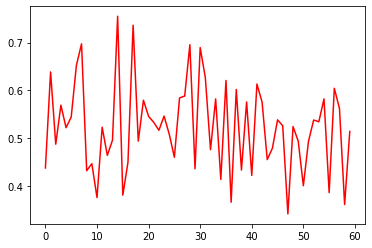

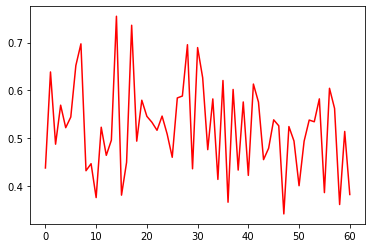

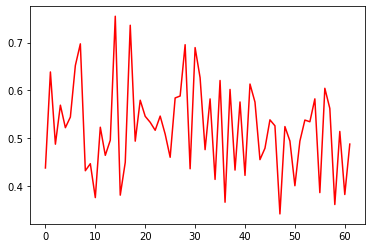

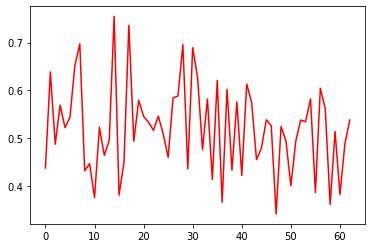

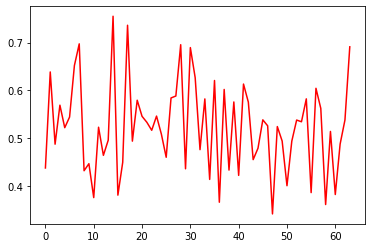

Epoch4,train loss 0.5416425604086655
Epoch4,val acc 82.07739307535641


  0%|          | 0/138 [00:00<?, ?it/s]

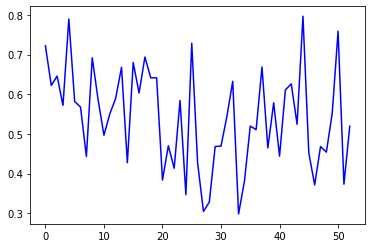

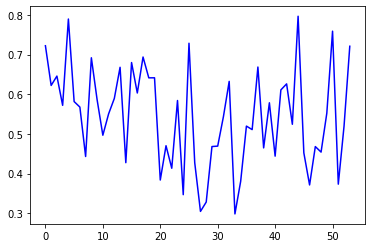

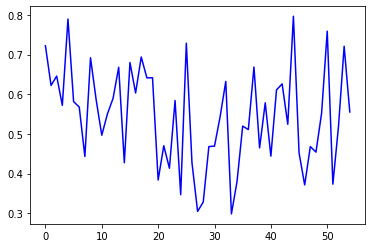

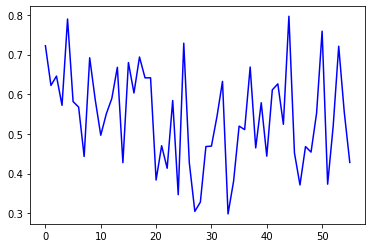

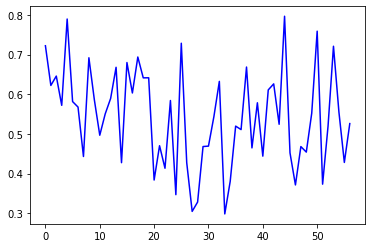

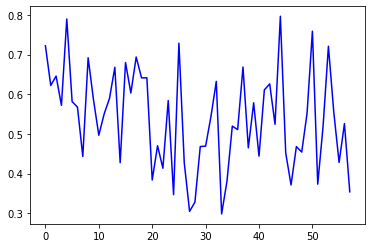

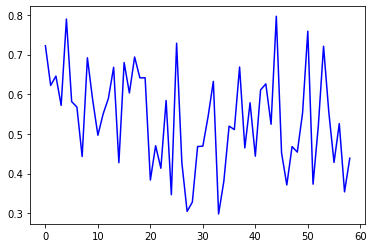

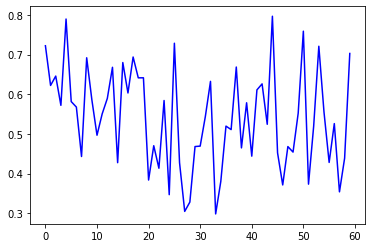

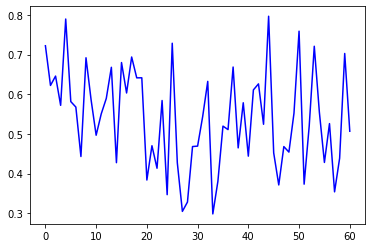

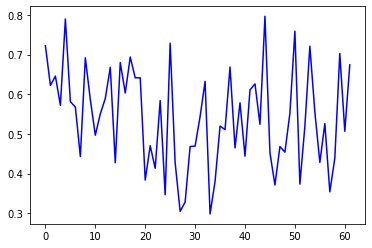

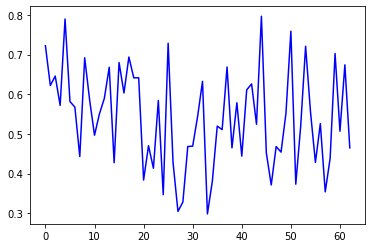

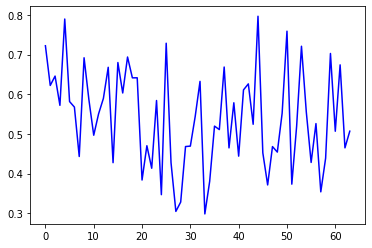

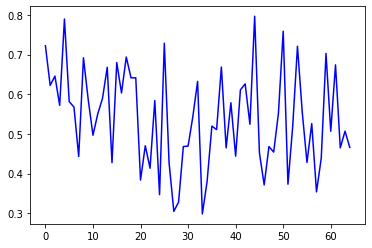

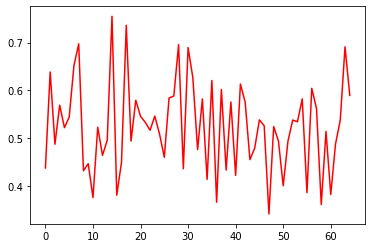

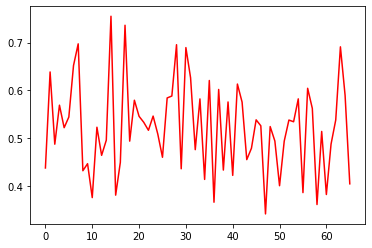

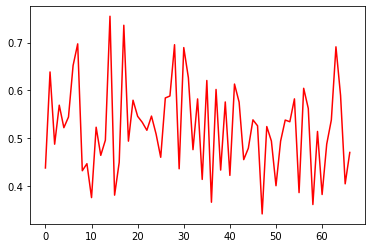

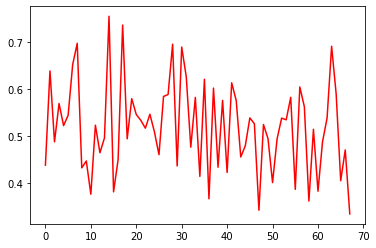

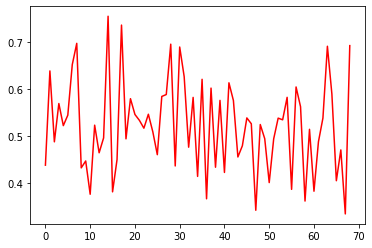

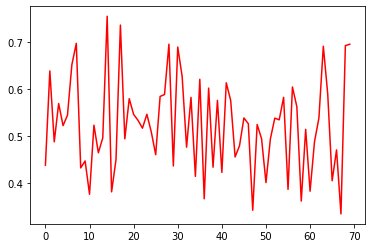

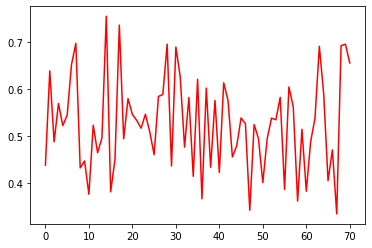

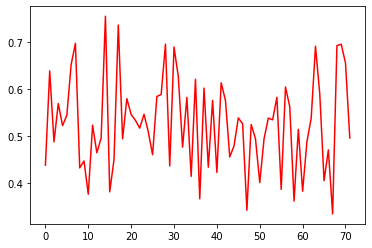

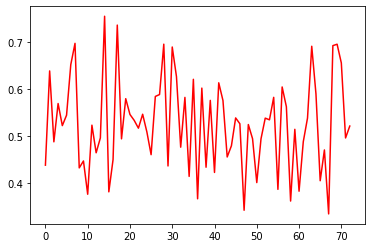

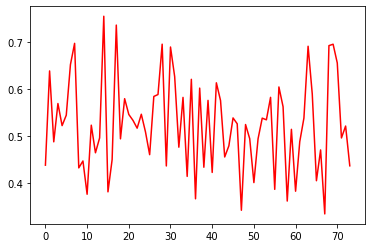

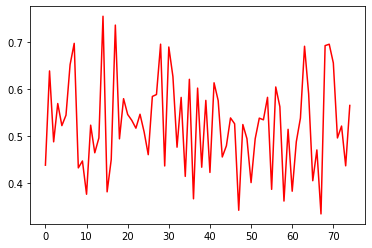

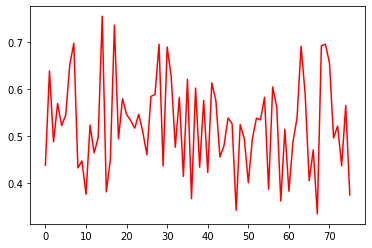

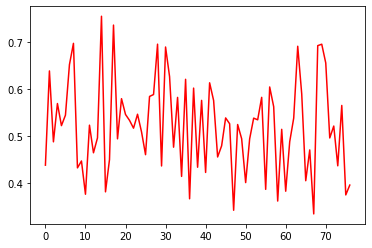

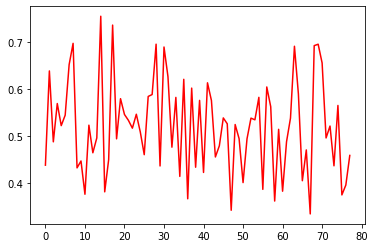

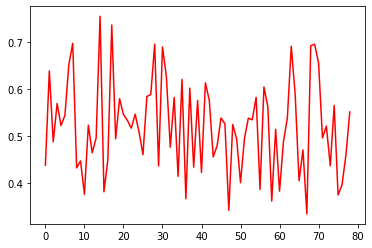

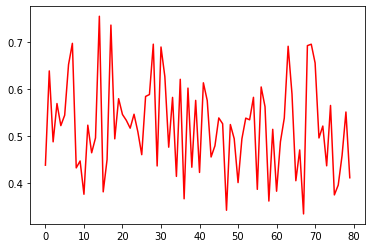

Epoch5,train loss 0.5388990232577691
Epoch5,val acc 74.949083503055


  0%|          | 0/138 [00:00<?, ?it/s]

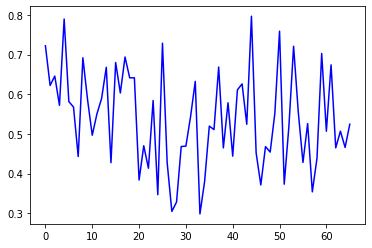

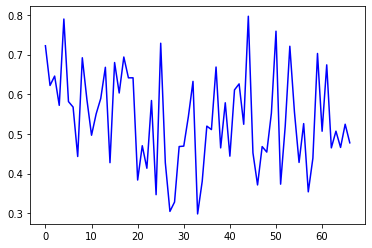

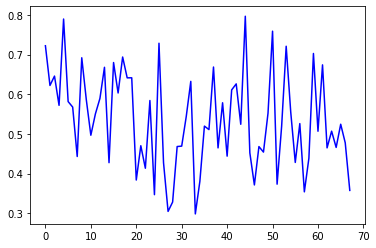

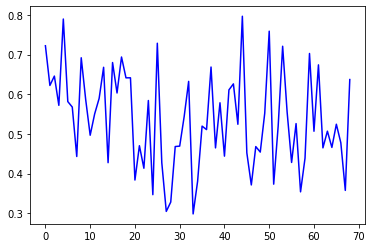

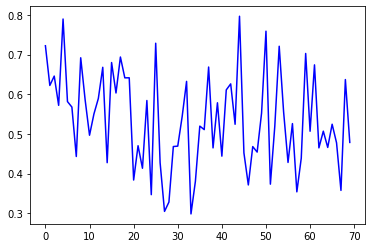

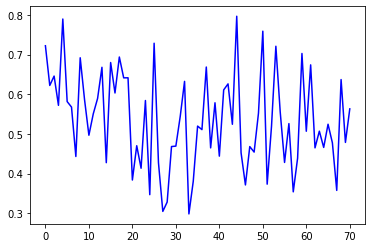

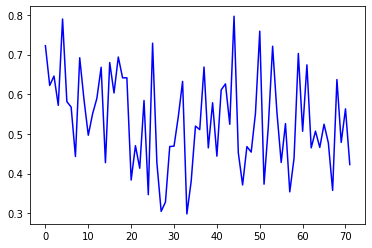

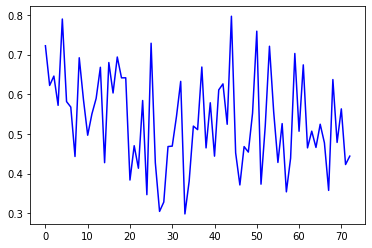

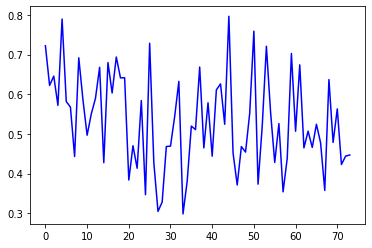

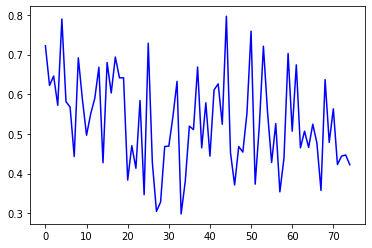

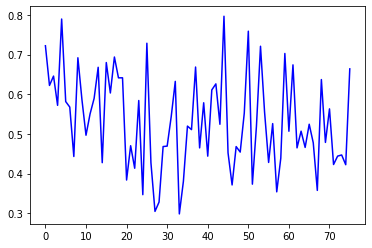

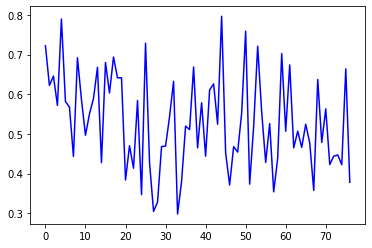

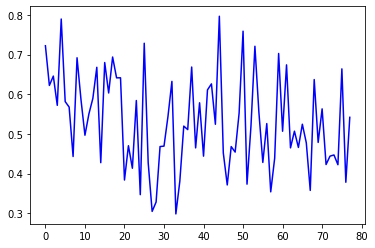

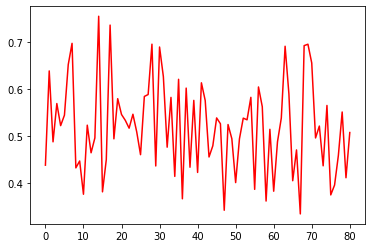

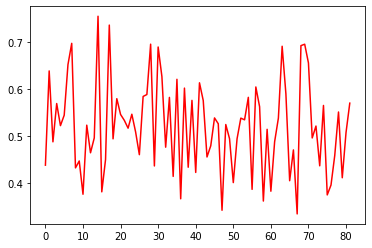

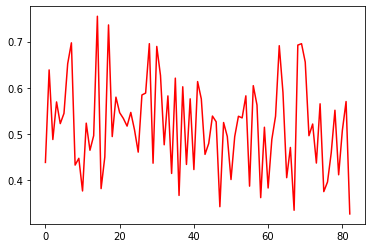

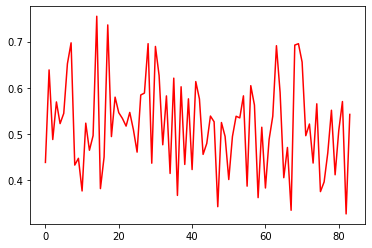

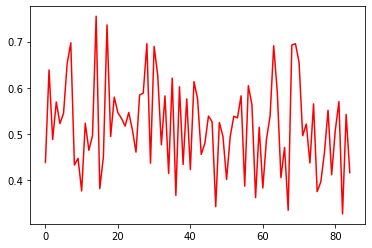

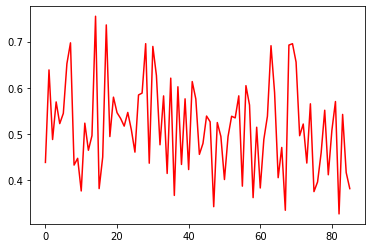

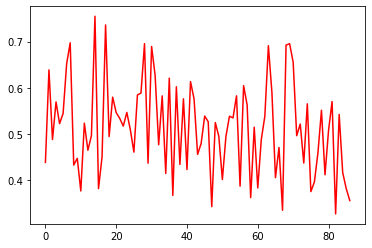

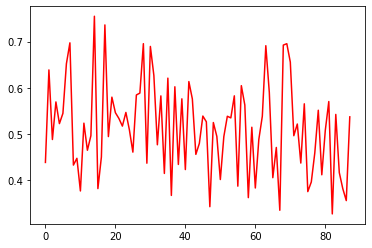

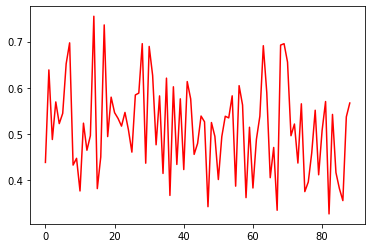

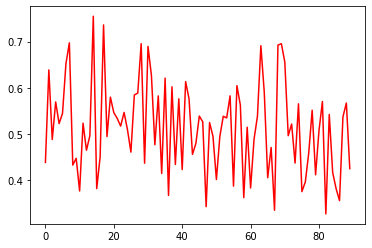

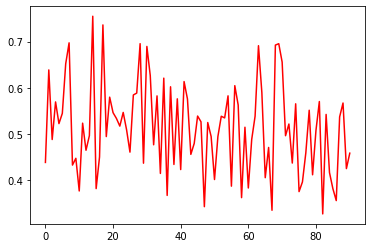

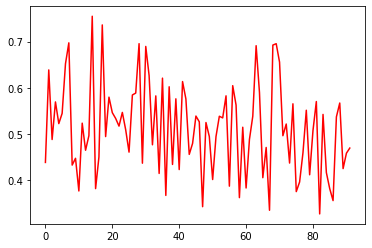

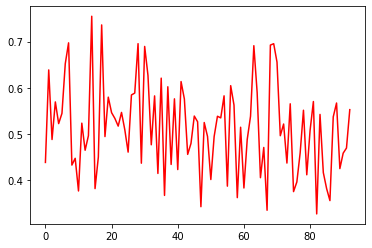

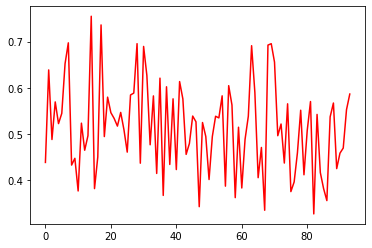

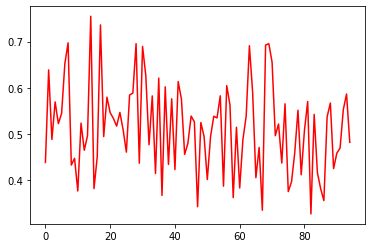

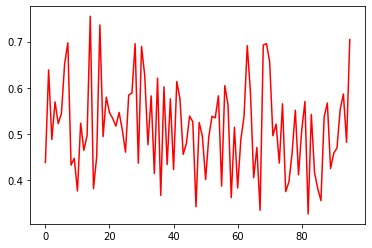

Epoch6,train loss 0.5305844766971393
Epoch6,val acc 70.87576374745417


  0%|          | 0/138 [00:00<?, ?it/s]

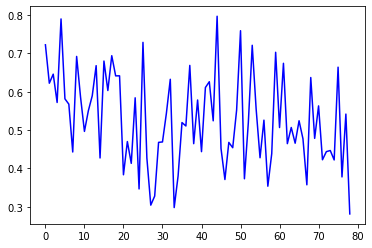

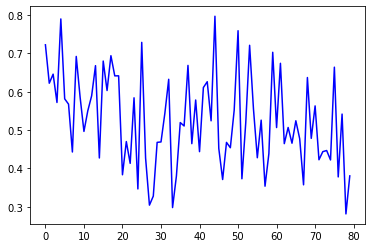

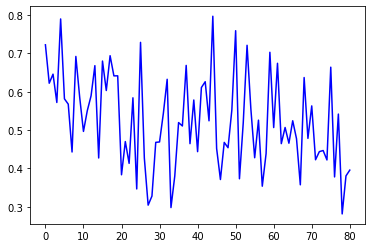

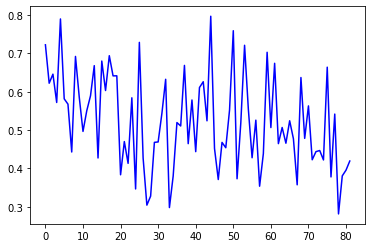

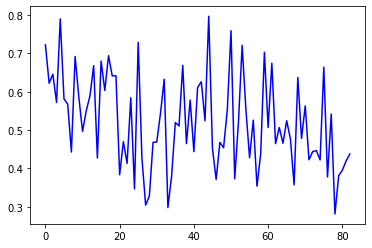

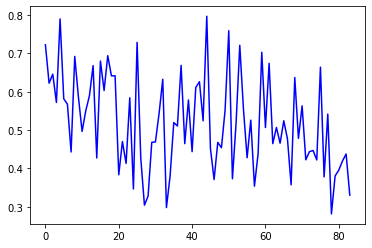

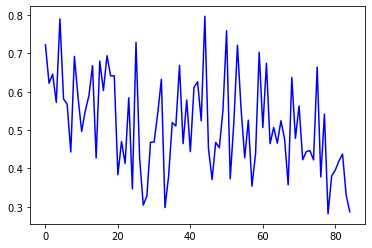

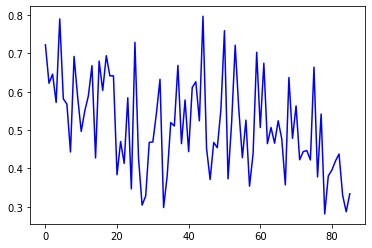

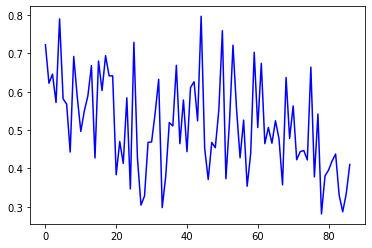

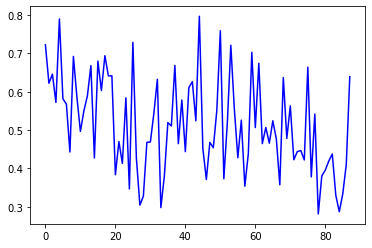

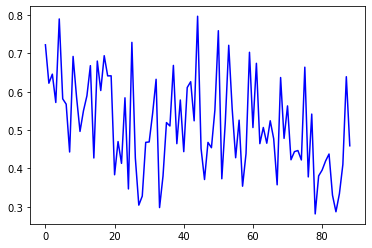

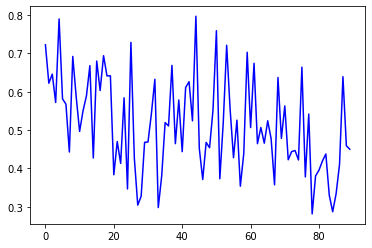

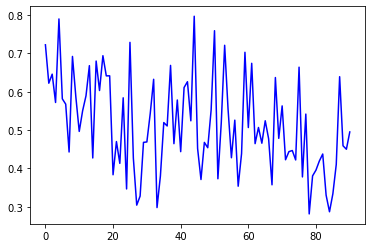

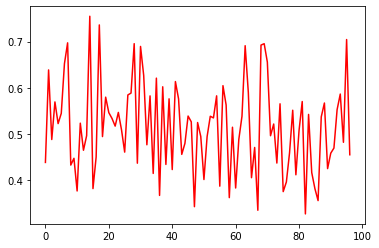

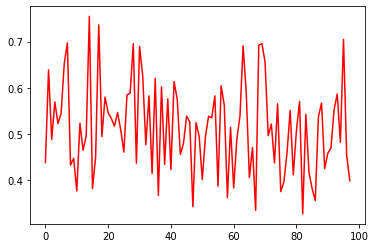

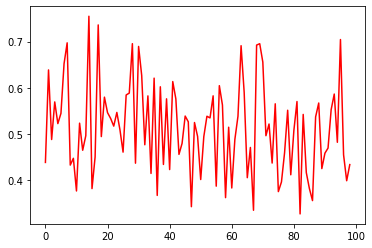

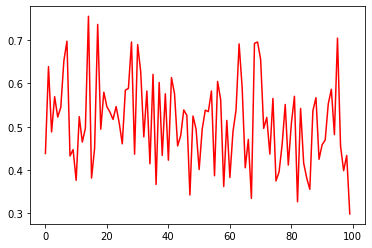

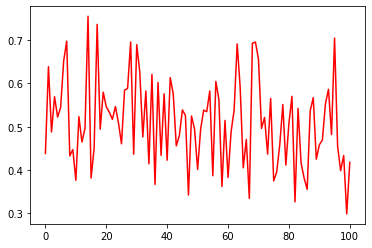

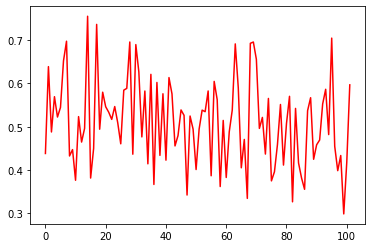

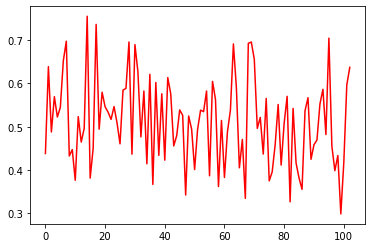

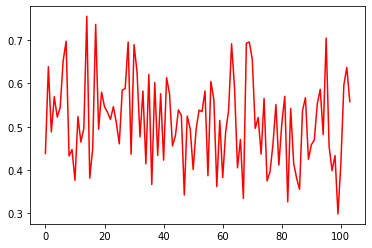

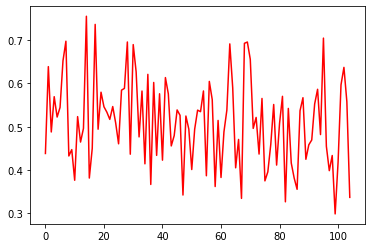

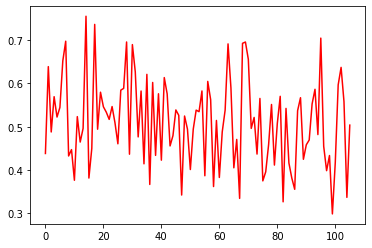

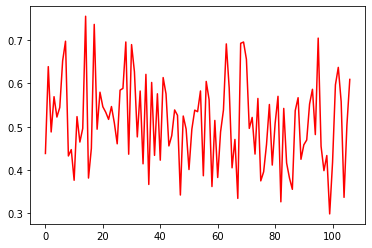

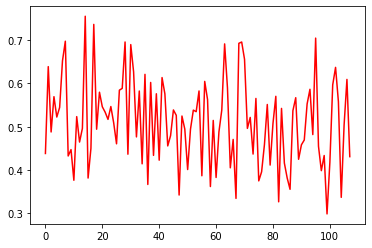

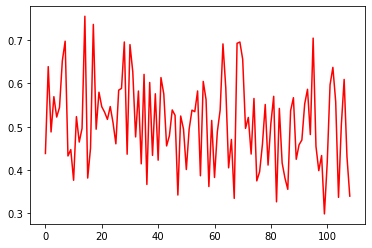

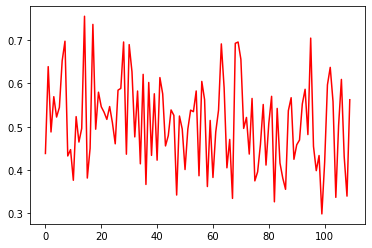

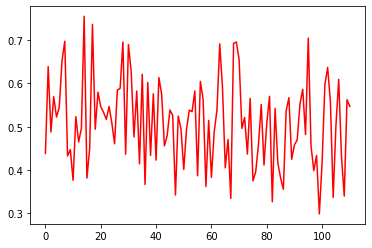

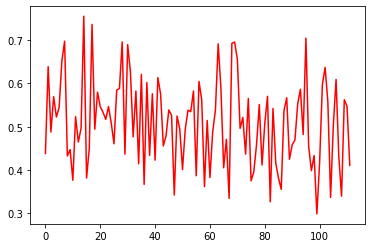

Epoch7,train loss 0.5132601297163701
Epoch7,val acc 73.72708757637474


  0%|          | 0/138 [00:00<?, ?it/s]

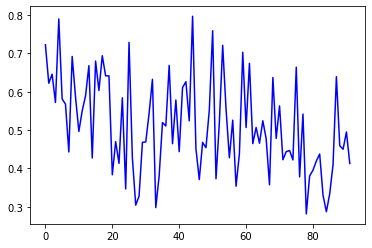

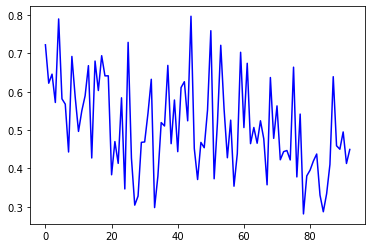

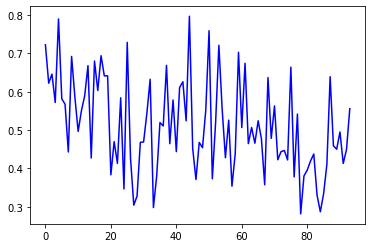

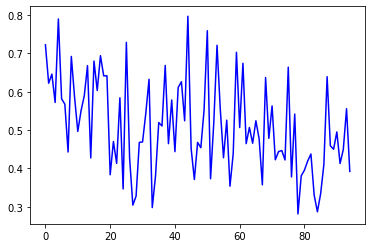

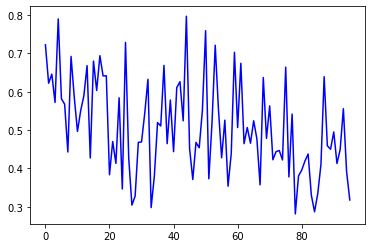

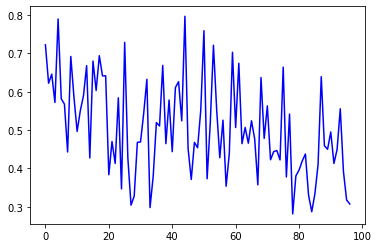

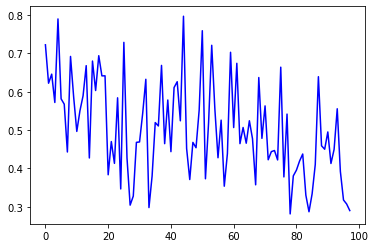

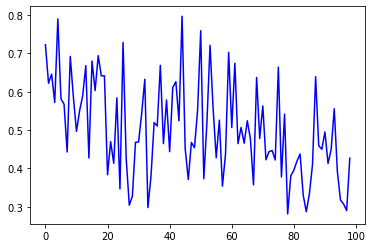

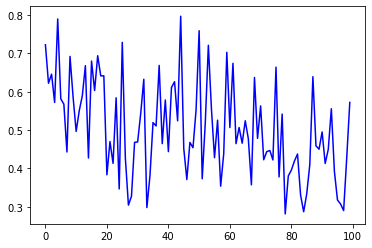

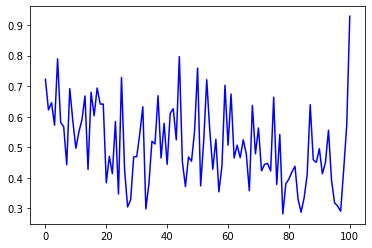

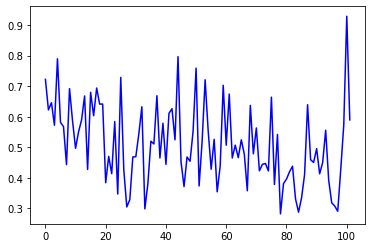

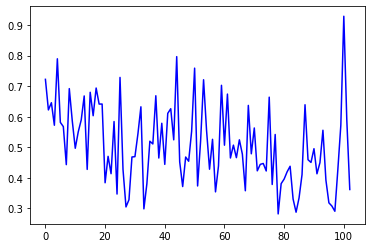

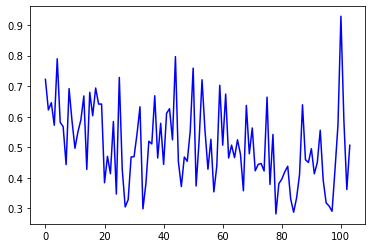

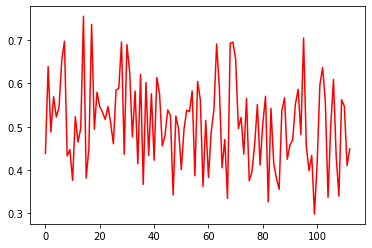

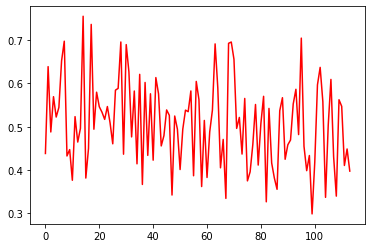

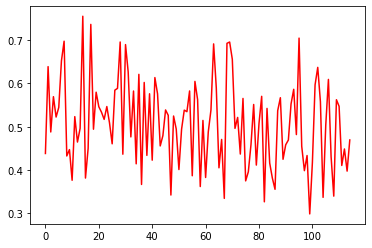

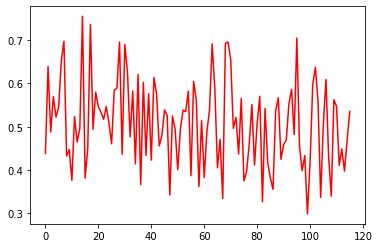

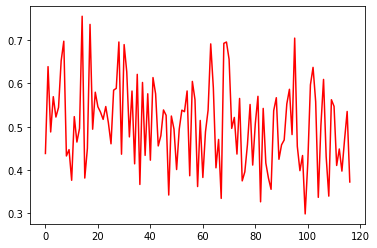

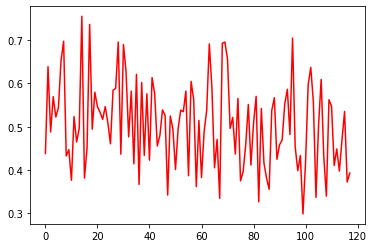

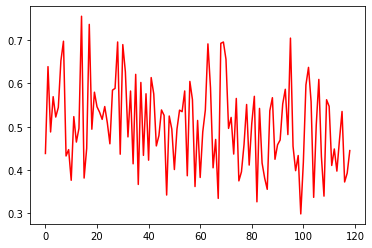

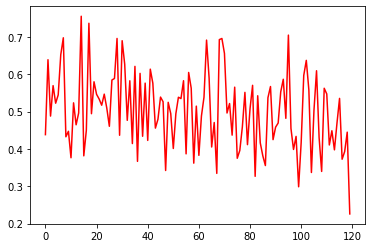

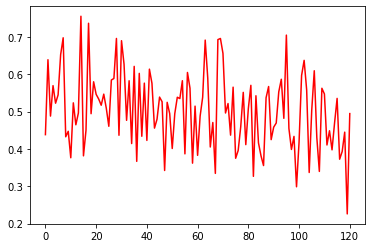

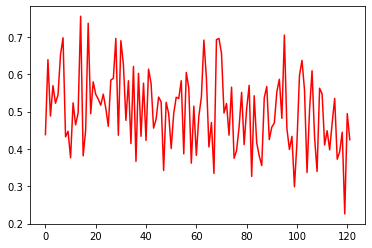

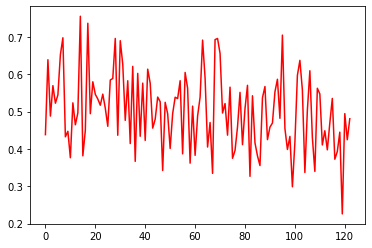

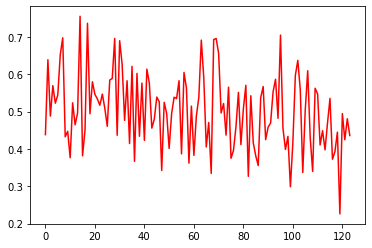

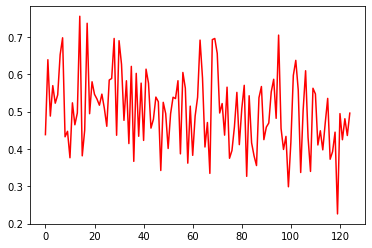

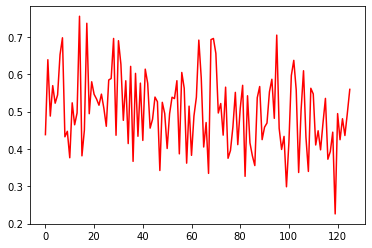

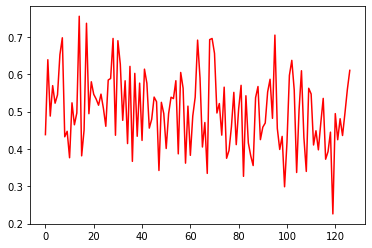

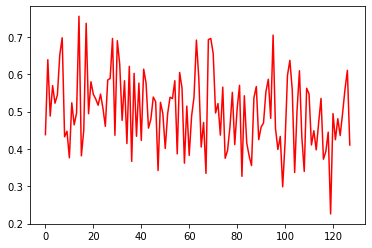

Epoch8,train loss 0.5078673655023942
Epoch8,val acc 74.74541751527495


  0%|          | 0/138 [00:00<?, ?it/s]

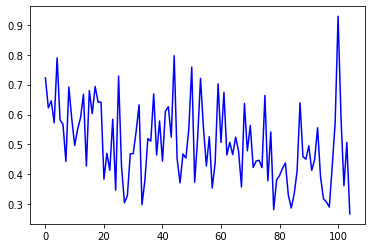

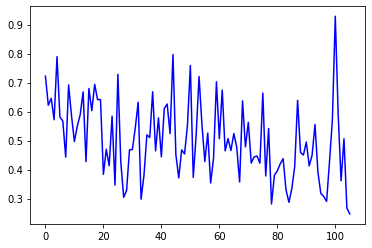

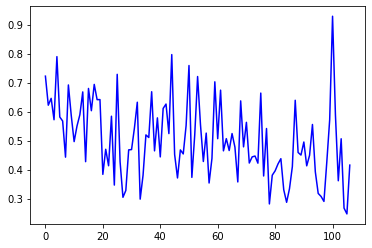

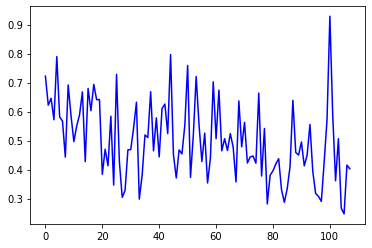

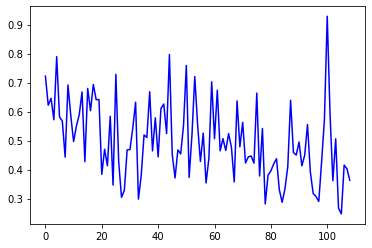

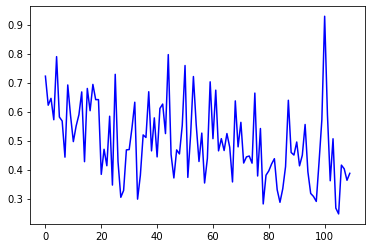

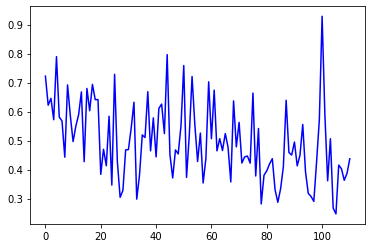

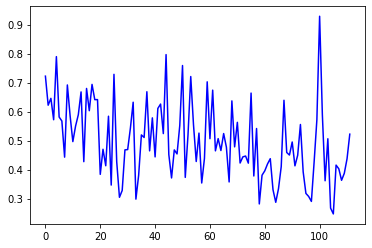

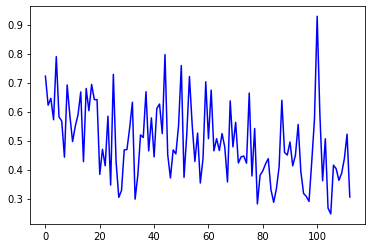

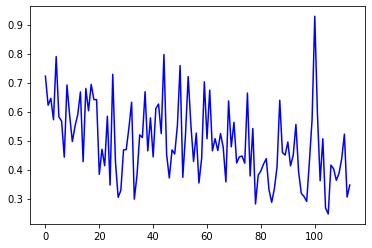

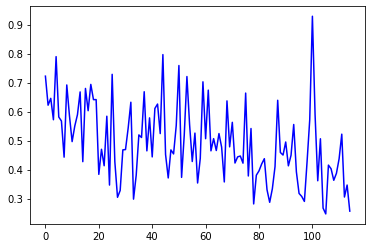

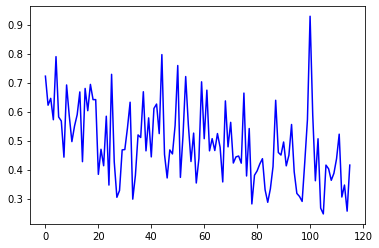

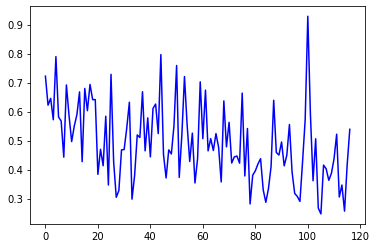

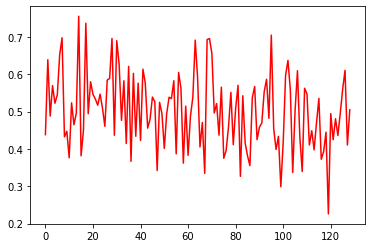

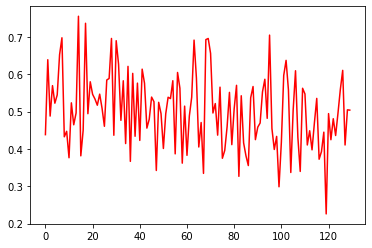

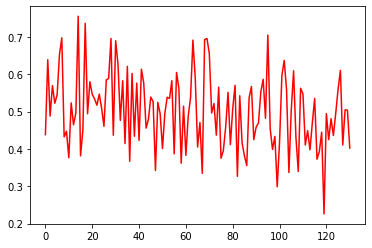

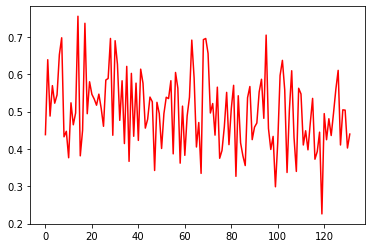

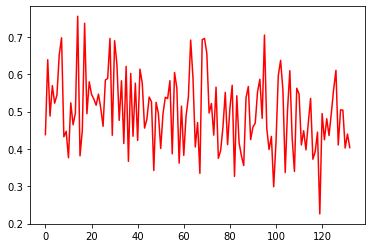

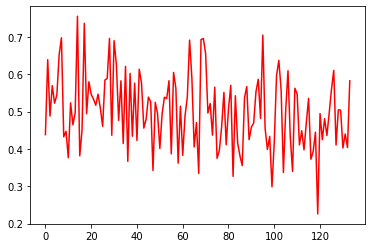

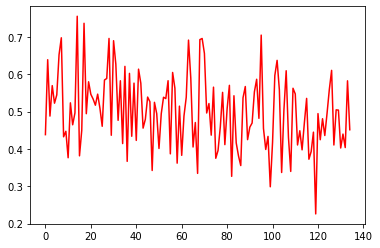

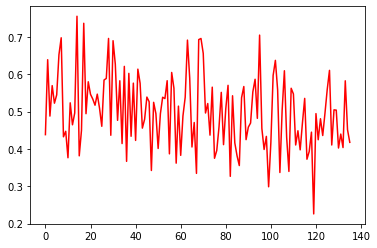

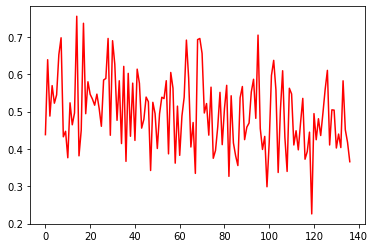

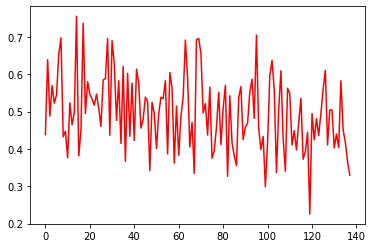

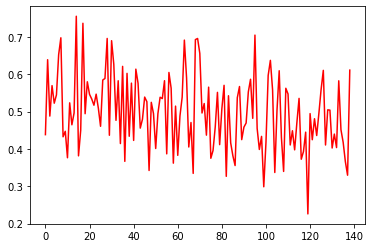

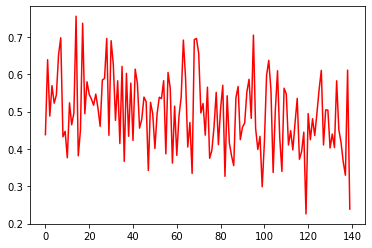

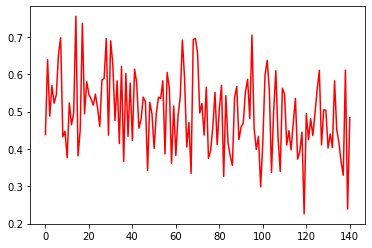

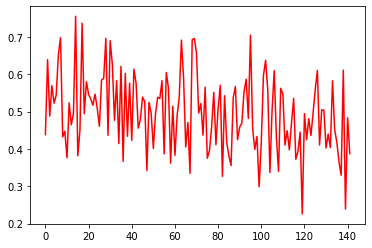

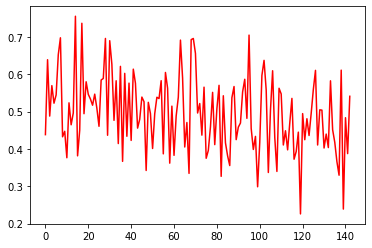

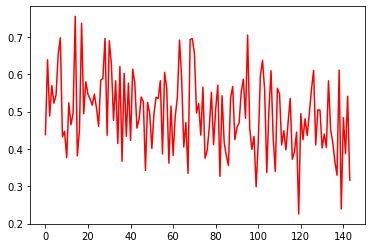

Epoch9,train loss 0.49336997349547523
Epoch9,val acc 81.05906313645622


  0%|          | 0/138 [00:00<?, ?it/s]

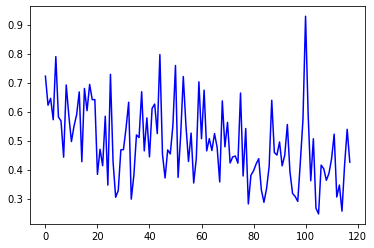

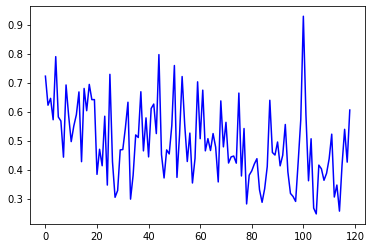

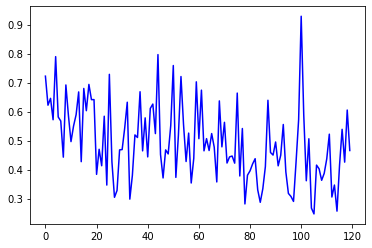

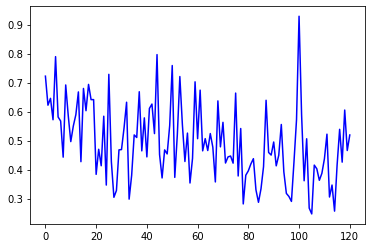

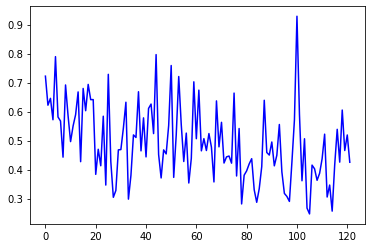

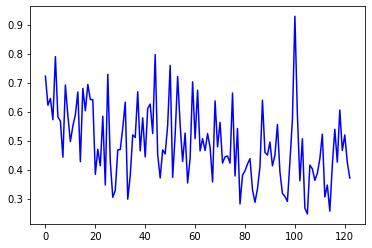

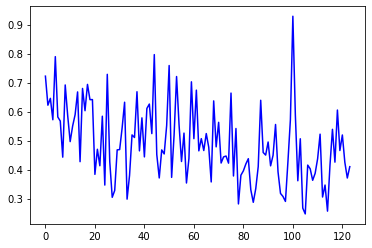

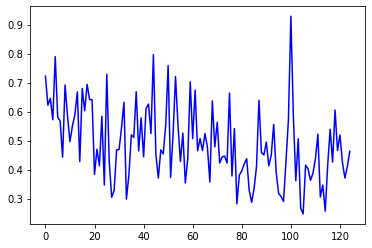

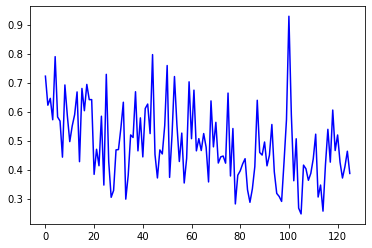

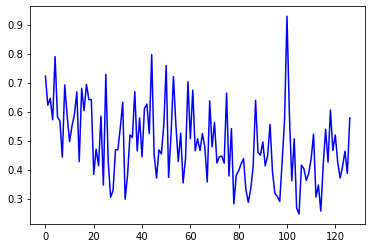

KeyboardInterrupt: 

In [24]:
#loss and optimizer
weights = torch.tensor([1.,3.4])
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.005)

#Training loop

n_total_step = len(train_loader)
acc_train = 0
losses_train = []
losses_val = []
for e in trange(epochs):
#train

    
    for i, (spec,label) in enumerate(tqdm(train_loader)):
        
        specs = spec.view(-1,1,input_size).to(device)
        labels = label.to(device)
        labels = labels.type(torch.LongTensor)
        
        #forward pass
        outputs = net( specs )
        loss = loss_function(outputs,labels.squeeze())
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%10 ==0:
            losses_train.append(loss.item())
            plt.plot(losses_train, color = 'blue')
            plt.show() 
#test
    with torch.no_grad():
        n_correct = 0
        n_sample = 0
        for i, (spec,label) in enumerate(val_loader):
            specs = spec.view(-1,1,input_size).to(device)
            labels = label.to(device)
            labels = labels.type(torch.LongTensor)

            outputs = net( specs )
            loss = loss_function(outputs,labels.squeeze())
            #forward pass
            _,predictions = torch.max(outputs,1)
            n_sample += labels.shape[0]
            n_correct += (predictions == labels.squeeze()).sum().item()

            losses_val.append(loss.item())
            plt.plot(losses_val, color = 'red')
            plt.show() 
        acc = 100 * n_correct / n_sample
    print(f'Epoch{e+1},train loss {sum(losses_train) / len(losses_train)}')
    print(f'Epoch{e+1},val acc {acc}')
       


In [25]:
with torch.no_grad():
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    total = 0
    n_correct = 0
    n_sample = 0
    for i, (spec,label) in enumerate(test_loader):
        specs = spec.view(-1,1,input_size).to(device)
        labels = label.to(device)
        labels = labels.type(torch.LongTensor)
        
        #forward pass
        outputs = net( specs )
        #print(outputs)
        #forward pass
        _,predictions = torch.max(outputs,1)
        for i in range(len(predictions)):
            if predictions[i] == labels[i]:
                if predictions[i] == 0:
                    TN+=1
                else:
                    TP+=1
            else:
                if predictions[i] == 0:
                    FN+=1
                else:
                    FP+=1
            total+=1
        n_sample += labels.shape[0]
        n_correct += (predictions == labels.squeeze()).sum().item()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    acc = n_correct / n_sample
    
print(f'accurracy:{acc}  sensitivity{sensitivity}  specificity{specificity} ')

accurracy:0.7913610431947841  sensitivity0.6564885496183206  specificity0.827979274611399 
